# Character classifier with Keras

## Description

We build a classifier to recognize English characters. We used the dataset called EnglishImg from http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/. This dataset contains digits and English carachters (lower and uppercase). We choose *Keras* to implement our classifier: when the depth of a neural network increases, it becomes difficult to take care of all parameters; differently from, e.g., TensorFlow or Theano, Keras provides an intuitive way to tune complex neural networks. We think it is the most appropriate library to build fast and efficient classifiers.

## Step 0 - Import libraries

First, we import the libraries used in the notebook.

In [13]:
import os
import keras
import string
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

/home/vekkiokonio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Step 1 - Variable initialization

First, we initialize the variables we are going to use in the notebook. After running the shell script format_dataset.sh, the dataset is moved to img/ and split into three folders (train/, valid/ and test/).

In [14]:
width = 224
height = 224
nb_epoch = 5
training_path = 'img_digits/train'
validation_path = "img_digits/valid"
test_path = "img_digits/test"
training_batch = 10
validation_batch = 4
test_batch = 10
nb_class = len(next(os.walk(training_path))[1])
class_label = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)

## Step 2 - Data loader

We build the dataset loader by using the *ImageDataGenerator* function of Keras. Preprocessing the images is important to train appropriately the network, and the parameters can be tuned (e.g., target size) to improve the classifier accuracy. What is more, the usage of the image mask can further improve performance.

In [15]:
datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range = 20,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                             fill_mode='nearest')

training = datagen.flow_from_directory(training_path,
                                       target_size = (width, height),
                                       batch_size = training_batch,
                                       class_mode = 'categorical')
validation = datagen.flow_from_directory(validation_path,
                                         target_size = (width, height),
                                         batch_size = validation_batch,
                                         class_mode = 'categorical')

nb_classes = len(next(os.walk(training_path))[1])

Found 200 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## Step 3 - Load the VGG model

In our classifier we used the pre-trained network called *VGG16* which has been trained with images. As an alternative, we could use, e.g., *resnet*.

In [16]:
vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (width, height, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

## Step 4 - Build the model

We fine tune the VGG model by adding four layers to reduce overfitting (*layers.Dropout()*), and output probabilities for classes (*layers.Dense()* with *softmax* activation function).

In [17]:
# Create the model and add the VGG convolutional base model
model = models.Sequential()
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_classes, activation = 'softmax'))

## Step 5 - Compile the model

We compile the model with the optimizer *RMSprop*. We tested *Adam* with default parameters, but it provided worse results.

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

## Step 6 - Train the model

We train the model over five epochs and we validate to analyze overfitting. We store the resulting weights in a file. Alternatively, it is possible to restore previous computed weights through the command *model.load_weights('model/vgg16.h5')*.

In [19]:
history = model.fit_generator(training,
                              steps_per_epoch = len(training),
                              epochs = nb_epoch,
                              validation_data = validation,
                              validation_steps = len(validation),
                              verbose = 2)

model.save_weights('model/vgg16_digits.h5')

Epoch 1/5
 - 188s - loss: 2.5533 - acc: 0.1650 - val_loss: 2.1085 - val_acc: 0.2600
Epoch 2/5
 - 191s - loss: 1.9915 - acc: 0.2450 - val_loss: 1.8968 - val_acc: 0.3200
Epoch 3/5
 - 194s - loss: 1.7070 - acc: 0.4600 - val_loss: 1.6012 - val_acc: 0.4200
Epoch 4/5
 - 197s - loss: 1.4207 - acc: 0.5300 - val_loss: 1.3209 - val_acc: 0.5000
Epoch 5/5
 - 192s - loss: 1.2203 - acc: 0.6050 - val_loss: 1.4378 - val_acc: 0.5000


## Step 7 - Plot the training graphs

We plot the accuracy and the loss per epoch for the training and the validation sets.

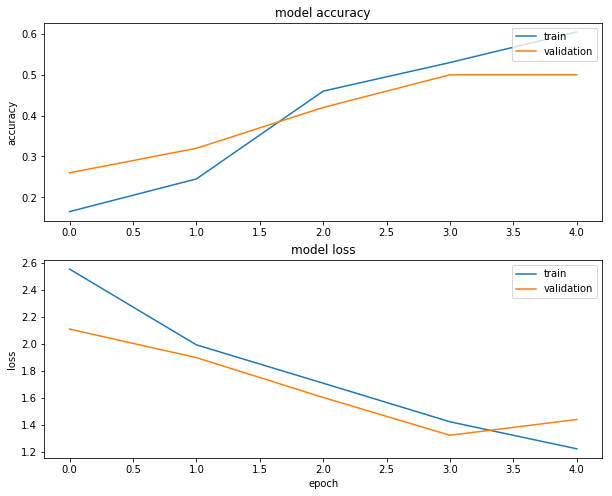

In [20]:
plt.figure(1, figsize = (10, 8))
   
# Plot accuracy
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.legend(['train', 'validation'], loc='upper right')  

# Plot loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper right')  
plt.show()  

## Step 8 - Make predictions on the test set

According to the model generated, we compute the probability that an image belongs to a certain class (*prediction_prob*). Conversely, the variable *prediction* describes which class has the highest probability per image. We also extract images (in *test_image*) and labels (in *test_label*) from the test set.

In [22]:
test = datagen.flow_from_directory(test_path,
                                   target_size = (width, height),
                                   batch_size = test_batch,
                                   shuffle = False,
                                   class_mode = 'categorical')

prediction_prob = model.predict_generator(test, steps = len(test))

# Choose the class with the highest probability
best_prediction = np.argmax(prediction_prob, axis = 1)
prediction = np.zeros((len(prediction_prob), nb_classes))

for i in range(len(best_prediction)):
    prediction[i, best_prediction[i]] = 1   

# Extract images and labels from the test set
test_image = []
test_label = np.zeros((len(prediction), nb_class))
test.reset()

i = 0
while i < len(test):
    x, y = test.next()

    for j in range(len(x)):
        type(x[j])
        test_image.append(x[j])
    
        for w in range(nb_class):
            test_label[i * 10 + j, w] = y[j][w]
    i += 1  

Found 343 images belonging to 10 classes.


## Step 9 - Print accuracy

We print the accuracy of the model as the percentage of correct predictions divided by the total number of predictions. The prediction used is the processed 0/1 variable *prediction* described in Step 8. A possible improvement of this metric should also take into account the probabilities of the predictions.

In [23]:
error = np.max(prediction - test_label, axis=1)
accuracy = np.around((1 - int(np.sum(error)) / len(prediction)) * 100, 2)
print('Accuracy:', accuracy, '% -', int(np.sum(error)), 'errors out of', len(prediction), 'images.')

Accuracy: 52.19 % - 164 errors out of 343 images.


## Step 10 - Show errors

This cell gives the opportunity to visually inspect on which images the classifier is making errors. This is important to analyze the result of the classifier, and improve the model accordingly.<br>
**RECOMMENDED USE:** limit the number of images to show when the number of errors is large.

Predict 1 with probability 0.55
Predict 0 with probability 0.08 (true label)


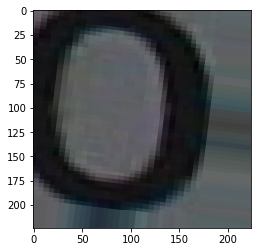

Predict 1 with probability 0.28
Predict 0 with probability 0.14 (true label)


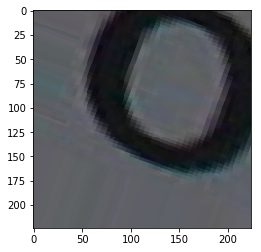

Predict 6 with probability 0.74
Predict 0 with probability 0.25 (true label)


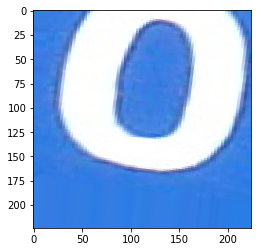

Predict 9 with probability 0.41
Predict 0 with probability 0.01 (true label)


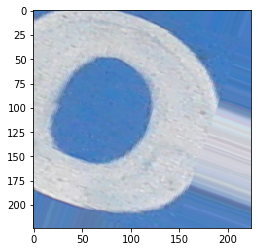

Predict 9 with probability 0.93
Predict 0 with probability 0.01 (true label)


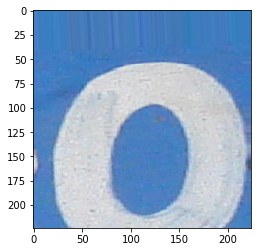

Predict 1 with probability 0.44
Predict 0 with probability 0.26 (true label)


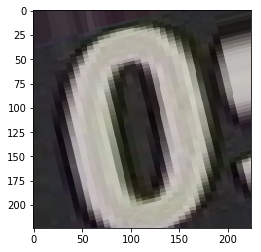

Predict 1 with probability 0.44
Predict 0 with probability 0.14 (true label)


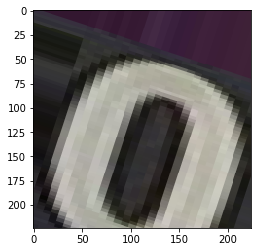

Predict 1 with probability 0.78
Predict 0 with probability 0.0 (true label)


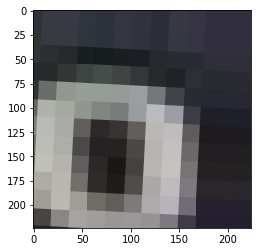

Predict 1 with probability 0.99
Predict 0 with probability 0.0 (true label)


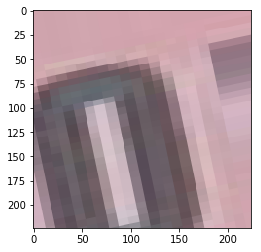

Predict 1 with probability 0.97
Predict 0 with probability 0.01 (true label)


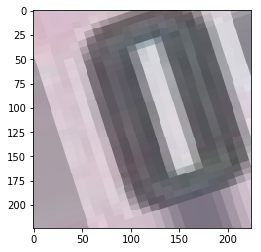

Predict 2 with probability 0.31
Predict 0 with probability 0.01 (true label)


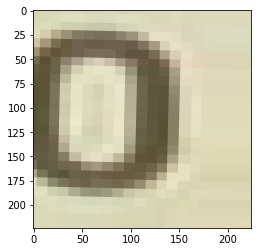

Predict 1 with probability 0.99
Predict 0 with probability 0.0 (true label)


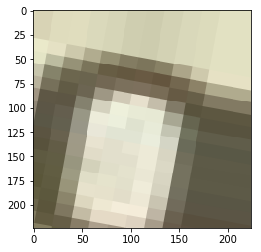

Predict 1 with probability 0.92
Predict 0 with probability 0.0 (true label)


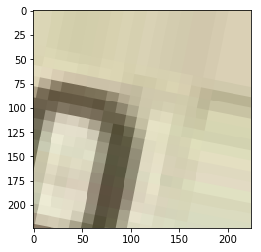

Predict 7 with probability 0.71
Predict 0 with probability 0.0 (true label)


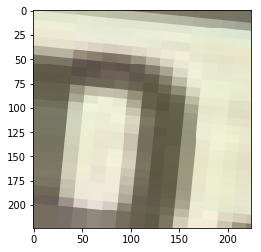

Predict 1 with probability 0.35
Predict 0 with probability 0.0 (true label)


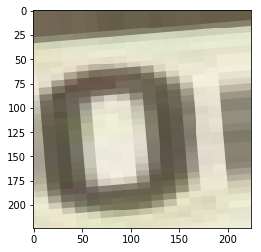

Predict 1 with probability 0.51
Predict 0 with probability 0.0 (true label)


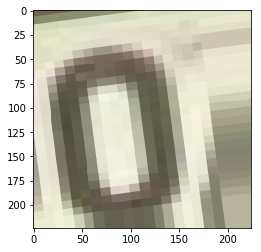

Predict 1 with probability 0.91
Predict 0 with probability 0.0 (true label)


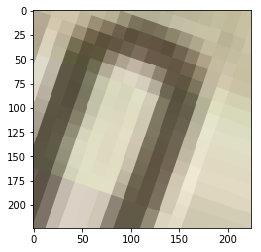

Predict 2 with probability 0.29
Predict 0 with probability 0.03 (true label)


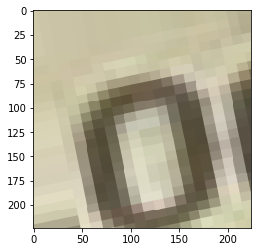

Predict 1 with probability 1.0
Predict 0 with probability 0.0 (true label)


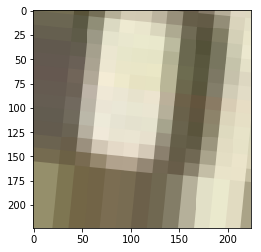

Predict 1 with probability 1.0
Predict 0 with probability 0.0 (true label)


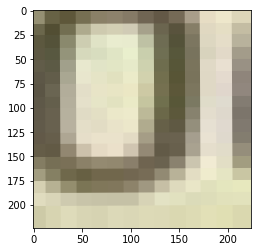

Predict 1 with probability 0.97
Predict 0 with probability 0.0 (true label)


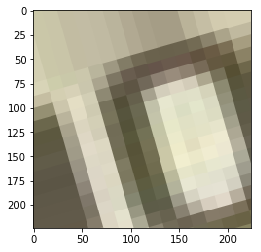

Predict 1 with probability 0.29
Predict 0 with probability 0.06 (true label)


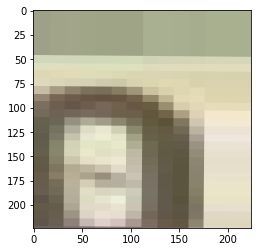

Predict 1 with probability 0.85
Predict 0 with probability 0.05 (true label)


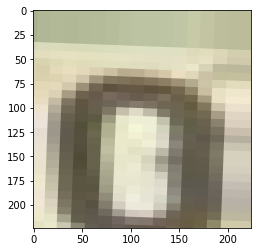

Predict 1 with probability 0.96
Predict 0 with probability 0.01 (true label)


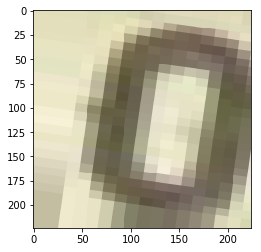

Predict 4 with probability 0.33
Predict 0 with probability 0.01 (true label)


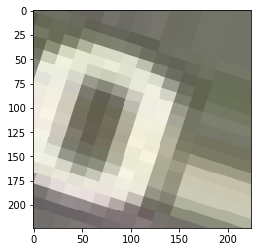

Predict 4 with probability 0.43
Predict 0 with probability 0.01 (true label)


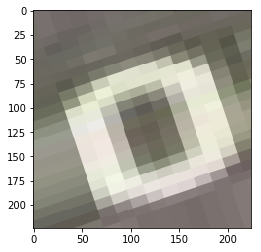

Predict 2 with probability 0.22
Predict 0 with probability 0.06 (true label)


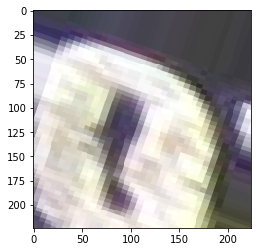

Predict 2 with probability 0.32
Predict 0 with probability 0.04 (true label)


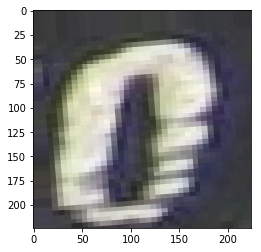

Predict 6 with probability 0.68
Predict 0 with probability 0.0 (true label)


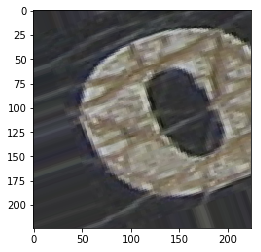

Predict 5 with probability 0.64
Predict 0 with probability 0.01 (true label)


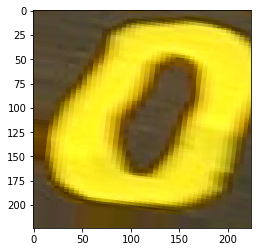

Predict 6 with probability 0.26
Predict 0 with probability 0.13 (true label)


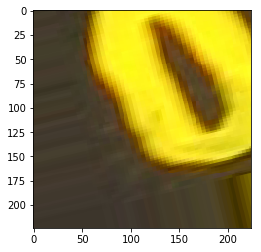

Predict 2 with probability 0.26
Predict 0 with probability 0.04 (true label)


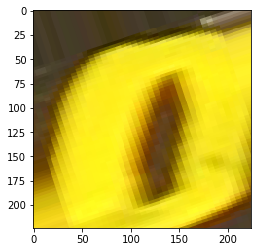

Predict 6 with probability 0.35
Predict 0 with probability 0.03 (true label)


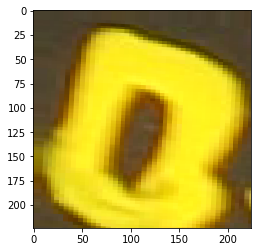

Predict 1 with probability 0.71
Predict 0 with probability 0.0 (true label)


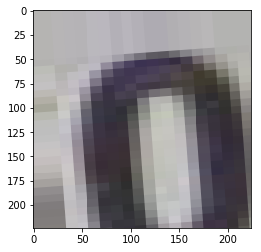

Predict 1 with probability 0.88
Predict 0 with probability 0.04 (true label)


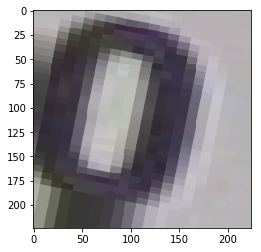

Predict 1 with probability 0.99
Predict 0 with probability 0.0 (true label)


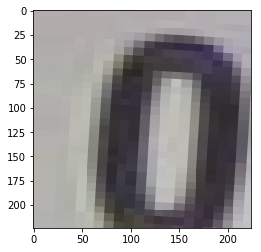

Predict 1 with probability 0.71
Predict 0 with probability 0.01 (true label)


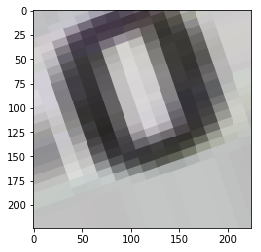

Predict 1 with probability 0.97
Predict 0 with probability 0.01 (true label)


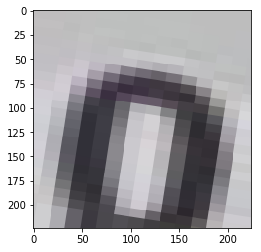

Predict 1 with probability 0.52
Predict 0 with probability 0.01 (true label)


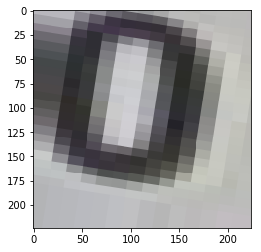

Predict 6 with probability 0.17
Predict 0 with probability 0.04 (true label)


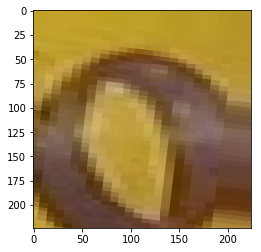

Predict 1 with probability 0.93
Predict 0 with probability 0.03 (true label)


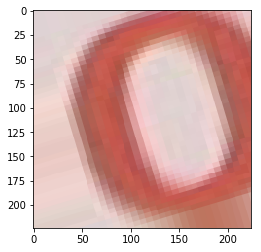

Predict 9 with probability 0.79
Predict 0 with probability 0.02 (true label)


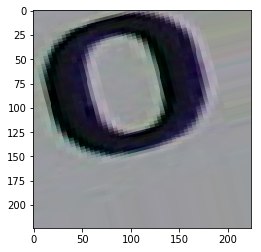

Predict 2 with probability 0.31
Predict 0 with probability 0.01 (true label)


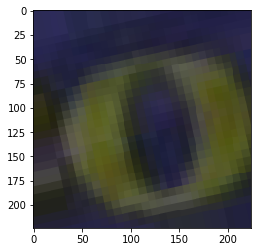

Predict 2 with probability 0.26
Predict 0 with probability 0.01 (true label)


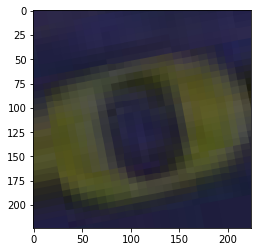

Predict 1 with probability 0.28
Predict 0 with probability 0.01 (true label)


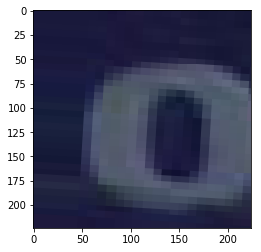

Predict 1 with probability 0.24
Predict 0 with probability 0.01 (true label)


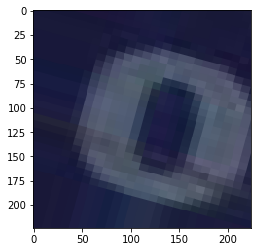

Predict 6 with probability 0.92
Predict 0 with probability 0.0 (true label)


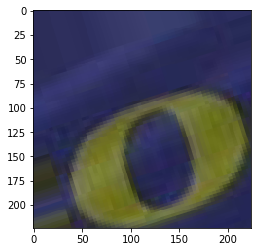

Predict 2 with probability 0.29
Predict 0 with probability 0.01 (true label)


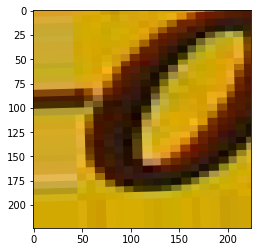

Predict 7 with probability 0.73
Predict 0 with probability 0.0 (true label)


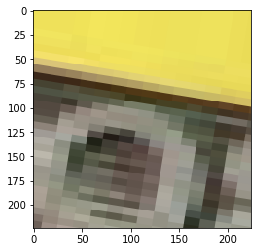

Predict 2 with probability 0.46
Predict 0 with probability 0.01 (true label)


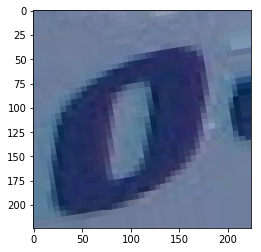

Predict 2 with probability 0.31
Predict 0 with probability 0.03 (true label)


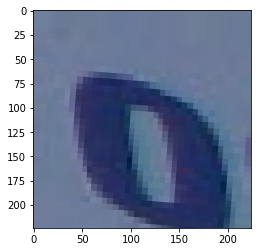

Predict 2 with probability 0.42
Predict 0 with probability 0.01 (true label)


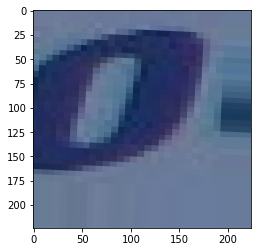

Predict 9 with probability 0.86
Predict 0 with probability 0.01 (true label)


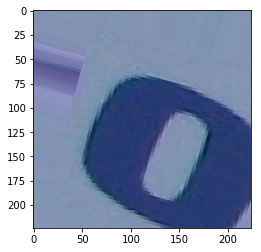

Predict 9 with probability 0.83
Predict 0 with probability 0.1 (true label)


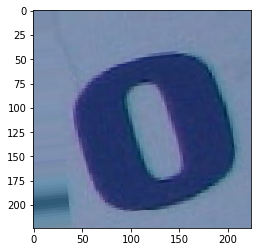

Predict 9 with probability 0.66
Predict 0 with probability 0.09 (true label)


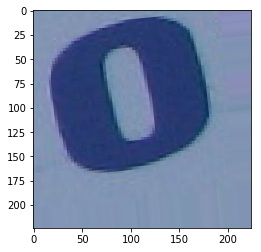

Predict 9 with probability 0.93
Predict 0 with probability 0.02 (true label)


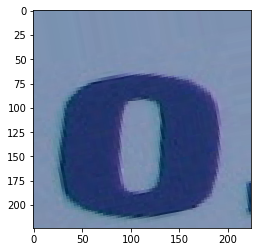

Predict 9 with probability 0.62
Predict 0 with probability 0.16 (true label)


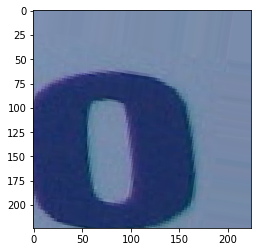

Predict 5 with probability 0.32
Predict 0 with probability 0.0 (true label)


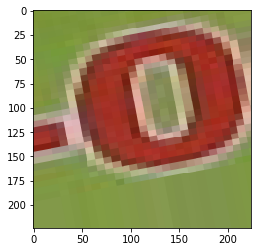

Predict 9 with probability 0.35
Predict 0 with probability 0.01 (true label)


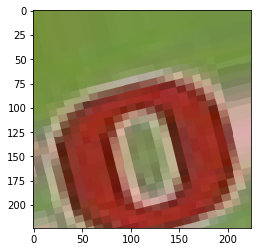

Predict 7 with probability 0.39
Predict 0 with probability 0.01 (true label)


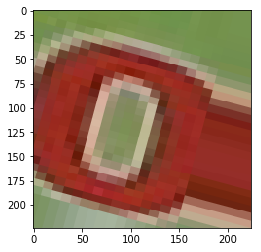

Predict 6 with probability 0.54
Predict 0 with probability 0.03 (true label)


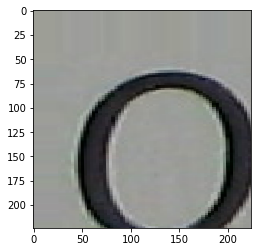

Predict 9 with probability 0.97
Predict 0 with probability 0.0 (true label)


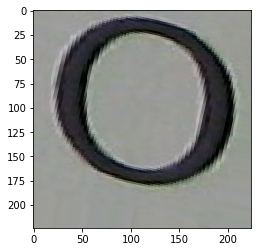

Predict 9 with probability 0.95
Predict 0 with probability 0.03 (true label)


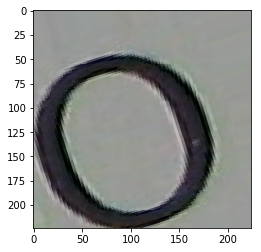

Predict 1 with probability 0.39
Predict 0 with probability 0.36 (true label)


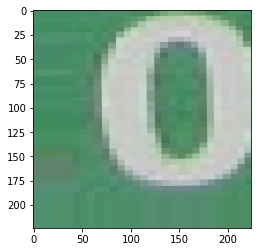

Predict 9 with probability 0.48
Predict 0 with probability 0.05 (true label)


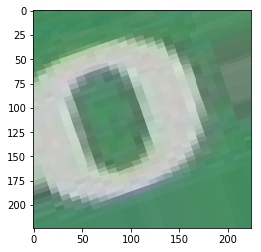

Predict 1 with probability 0.72
Predict 0 with probability 0.04 (true label)


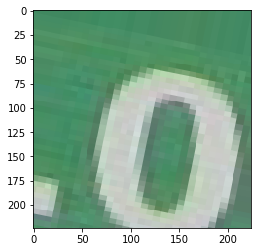

Predict 4 with probability 0.28
Predict 0 with probability 0.04 (true label)


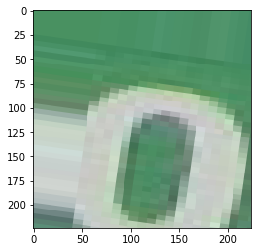

Predict 9 with probability 0.29
Predict 0 with probability 0.25 (true label)


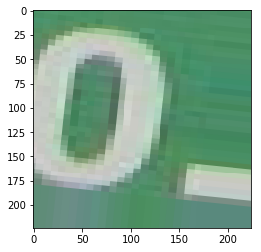

Predict 6 with probability 0.46
Predict 0 with probability 0.01 (true label)


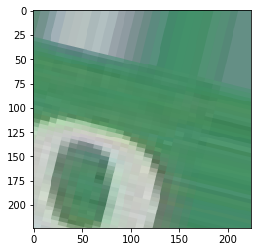

Predict 5 with probability 0.82
Predict 0 with probability 0.0 (true label)


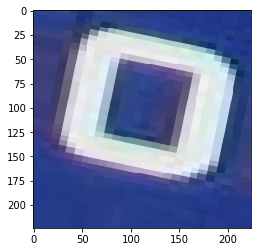

Predict 2 with probability 0.43
Predict 1 with probability 0.03 (true label)


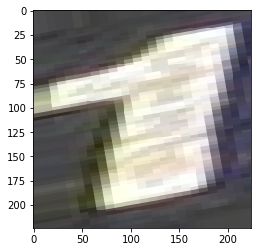

Predict 5 with probability 0.19
Predict 1 with probability 0.16 (true label)


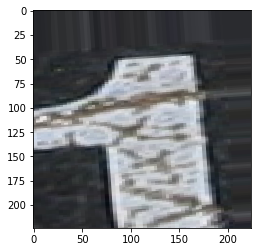

Predict 4 with probability 0.76
Predict 1 with probability 0.16 (true label)


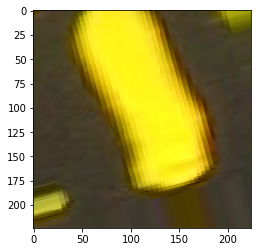

Predict 2 with probability 0.29
Predict 1 with probability 0.09 (true label)


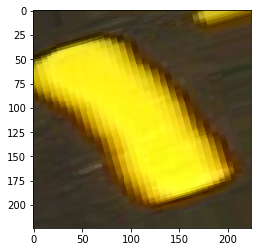

Predict 2 with probability 0.34
Predict 1 with probability 0.11 (true label)


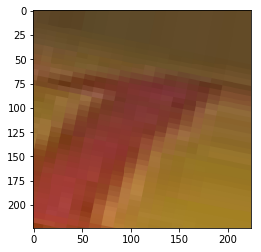

Predict 4 with probability 0.28
Predict 1 with probability 0.08 (true label)


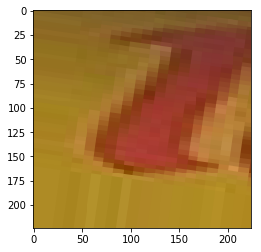

Predict 2 with probability 0.5
Predict 1 with probability 0.05 (true label)


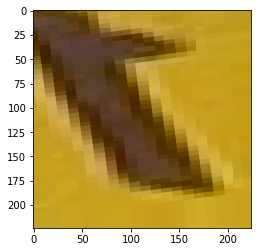

Predict 2 with probability 0.37
Predict 1 with probability 0.09 (true label)


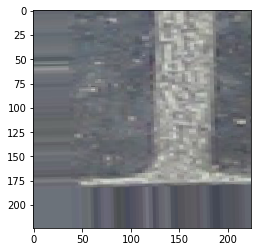

Predict 4 with probability 0.29
Predict 1 with probability 0.23 (true label)


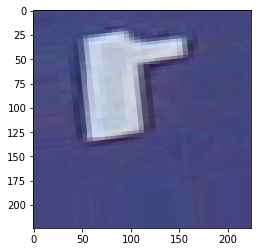

Predict 2 with probability 0.48
Predict 1 with probability 0.01 (true label)


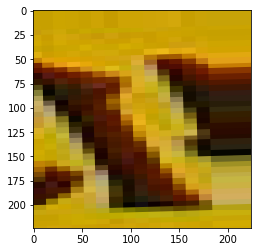

Predict 2 with probability 0.26
Predict 1 with probability 0.2 (true label)


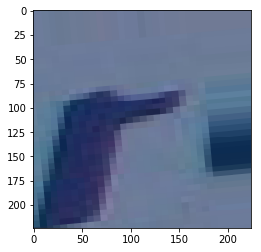

Predict 2 with probability 0.55
Predict 1 with probability 0.07 (true label)


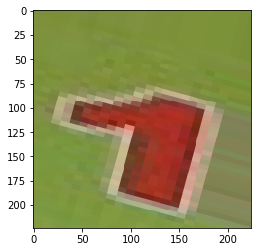

Predict 4 with probability 0.39
Predict 1 with probability 0.23 (true label)


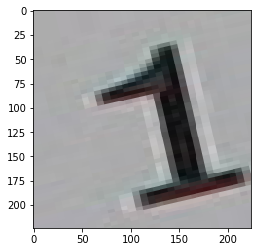

Predict 9 with probability 0.41
Predict 2 with probability 0.27 (true label)


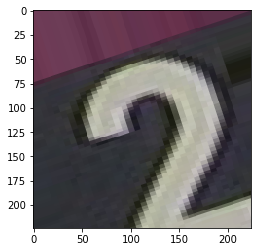

Predict 5 with probability 0.49
Predict 2 with probability 0.09 (true label)


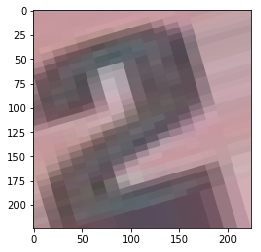

Predict 3 with probability 0.31
Predict 2 with probability 0.06 (true label)


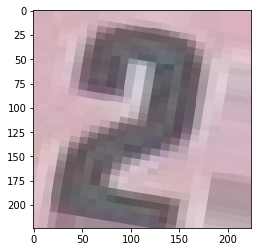

Predict 4 with probability 0.37
Predict 2 with probability 0.08 (true label)


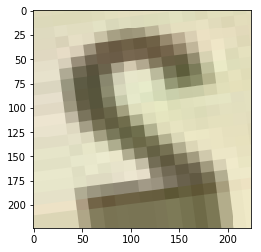

Predict 3 with probability 0.47
Predict 2 with probability 0.07 (true label)


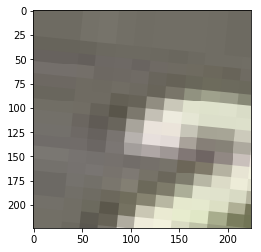

Predict 9 with probability 0.49
Predict 2 with probability 0.19 (true label)


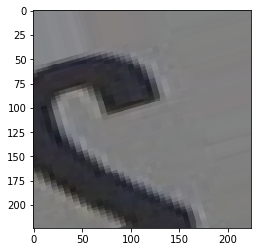

Predict 3 with probability 0.34
Predict 2 with probability 0.2 (true label)


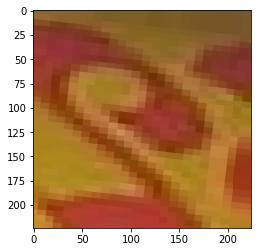

Predict 5 with probability 0.43
Predict 2 with probability 0.19 (true label)


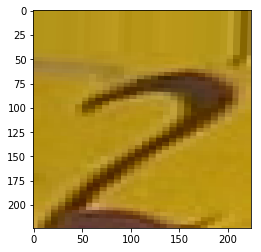

Predict 3 with probability 0.27
Predict 2 with probability 0.1 (true label)


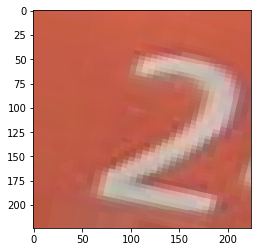

Predict 5 with probability 0.29
Predict 3 with probability 0.28 (true label)


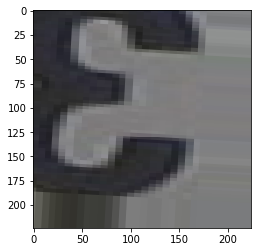

Predict 2 with probability 0.57
Predict 3 with probability 0.11 (true label)


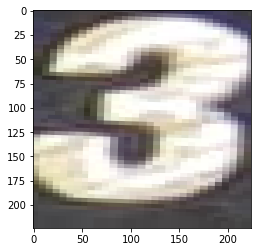

Predict 2 with probability 0.32
Predict 3 with probability 0.32 (true label)


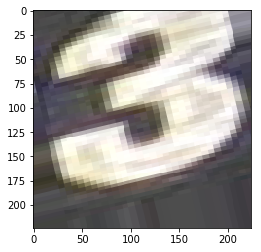

Predict 5 with probability 0.81
Predict 3 with probability 0.06 (true label)


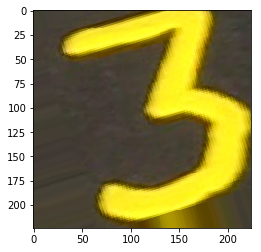

Predict 5 with probability 0.68
Predict 3 with probability 0.26 (true label)


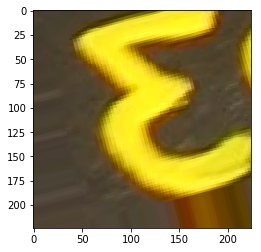

Predict 5 with probability 0.39
Predict 3 with probability 0.3 (true label)


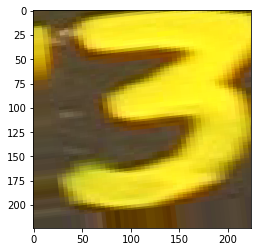

Predict 5 with probability 0.78
Predict 3 with probability 0.15 (true label)


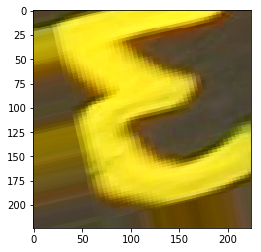

Predict 5 with probability 0.34
Predict 3 with probability 0.3 (true label)


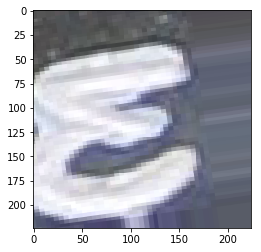

Predict 5 with probability 0.36
Predict 3 with probability 0.22 (true label)


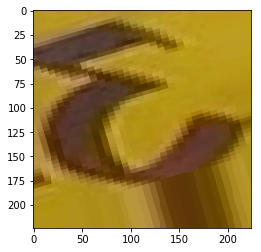

Predict 5 with probability 0.9
Predict 3 with probability 0.04 (true label)


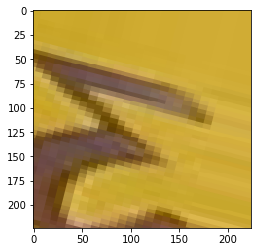

Predict 5 with probability 0.83
Predict 3 with probability 0.04 (true label)


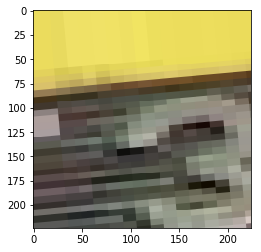

Predict 6 with probability 0.31
Predict 3 with probability 0.3 (true label)


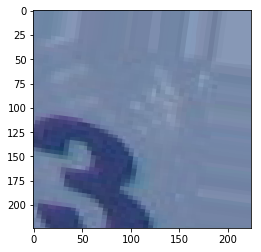

Predict 5 with probability 0.68
Predict 3 with probability 0.05 (true label)


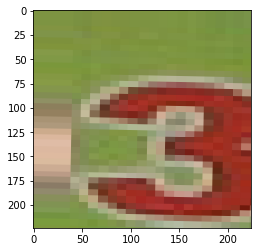

Predict 2 with probability 0.58
Predict 4 with probability 0.1 (true label)


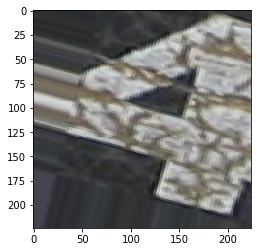

Predict 1 with probability 0.81
Predict 4 with probability 0.16 (true label)


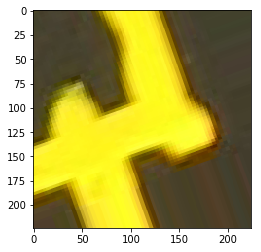

Predict 5 with probability 0.26
Predict 4 with probability 0.15 (true label)


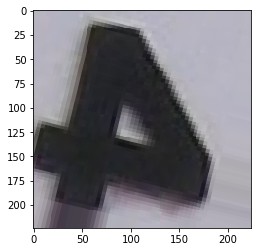

Predict 2 with probability 0.4
Predict 4 with probability 0.28 (true label)


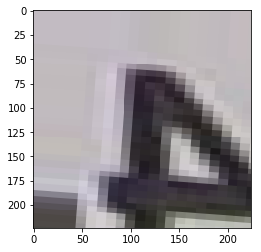

Predict 5 with probability 0.48
Predict 4 with probability 0.32 (true label)


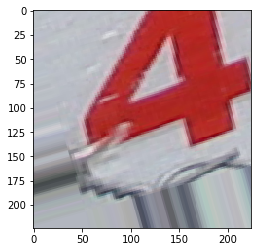

Predict 3 with probability 0.38
Predict 4 with probability 0.02 (true label)


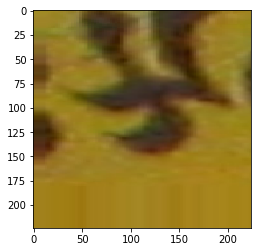

Predict 3 with probability 0.56
Predict 4 with probability 0.04 (true label)


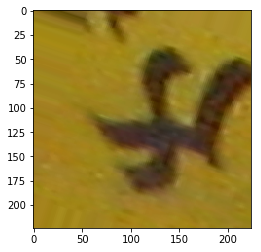

Predict 2 with probability 0.93
Predict 4 with probability 0.03 (true label)


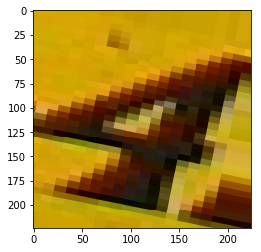

Predict 2 with probability 0.79
Predict 4 with probability 0.03 (true label)


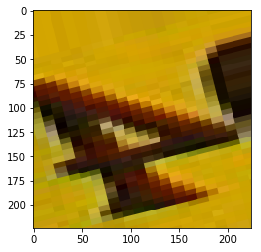

Predict 7 with probability 0.7
Predict 5 with probability 0.29 (true label)


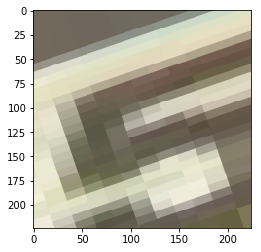

Predict 3 with probability 0.45
Predict 5 with probability 0.13 (true label)


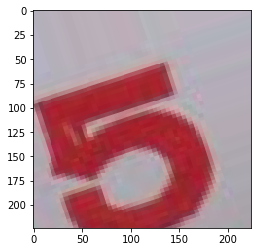

Predict 3 with probability 0.36
Predict 5 with probability 0.3 (true label)


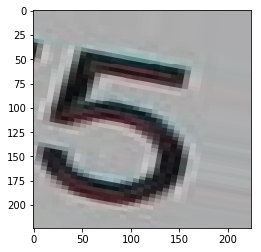

Predict 2 with probability 0.43
Predict 6 with probability 0.09 (true label)


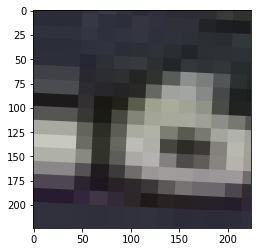

Predict 7 with probability 0.31
Predict 6 with probability 0.03 (true label)


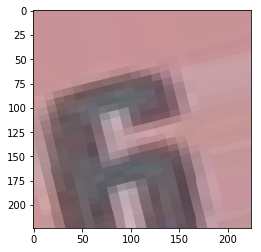

Predict 5 with probability 0.52
Predict 6 with probability 0.09 (true label)


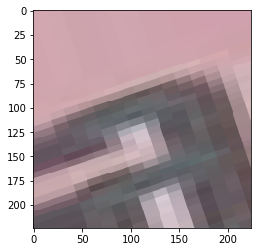

Predict 5 with probability 0.27
Predict 6 with probability 0.04 (true label)


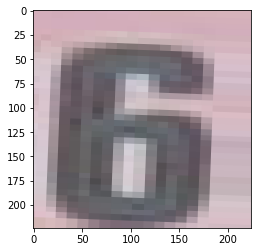

Predict 7 with probability 0.26
Predict 6 with probability 0.04 (true label)


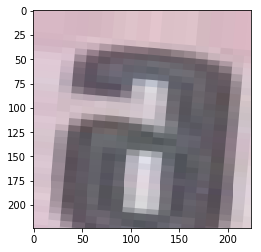

Predict 1 with probability 0.7
Predict 6 with probability 0.02 (true label)


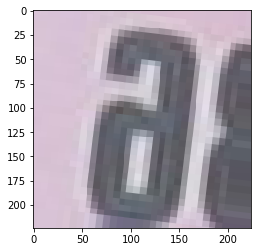

Predict 3 with probability 0.42
Predict 6 with probability 0.08 (true label)


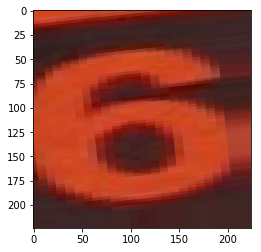

Predict 8 with probability 0.62
Predict 6 with probability 0.1 (true label)


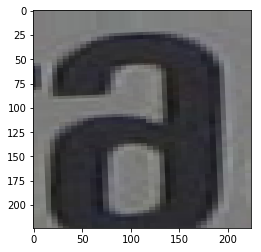

Predict 1 with probability 0.34
Predict 6 with probability 0.19 (true label)


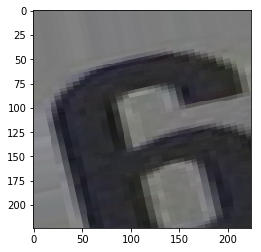

Predict 8 with probability 0.23
Predict 6 with probability 0.19 (true label)


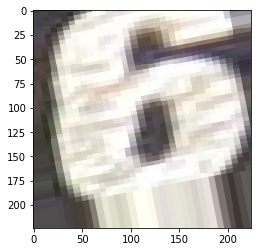

Predict 3 with probability 0.32
Predict 6 with probability 0.05 (true label)


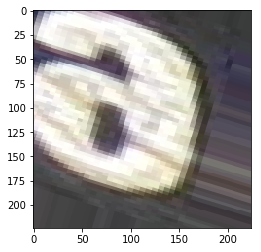

Predict 1 with probability 0.25
Predict 6 with probability 0.05 (true label)


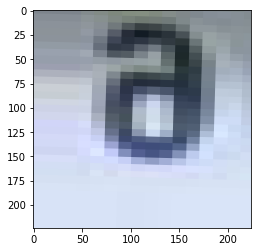

Predict 1 with probability 0.37
Predict 6 with probability 0.09 (true label)


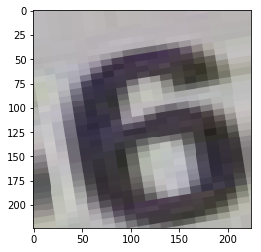

Predict 2 with probability 0.42
Predict 6 with probability 0.1 (true label)


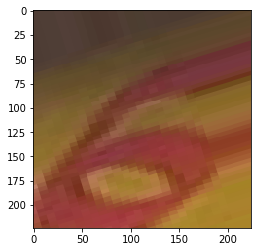

Predict 2 with probability 0.23
Predict 6 with probability 0.12 (true label)


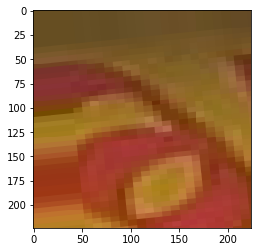

Predict 9 with probability 0.42
Predict 6 with probability 0.02 (true label)


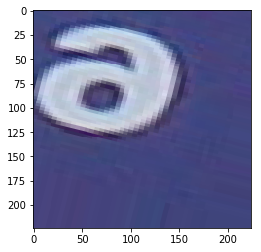

Predict 3 with probability 0.33
Predict 6 with probability 0.08 (true label)


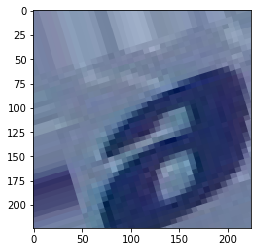

Predict 9 with probability 0.41
Predict 6 with probability 0.13 (true label)


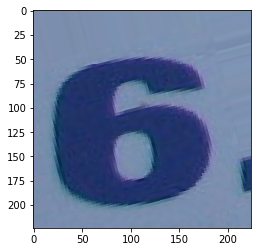

Predict 3 with probability 0.32
Predict 6 with probability 0.19 (true label)


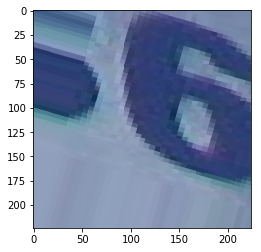

Predict 5 with probability 0.46
Predict 6 with probability 0.13 (true label)


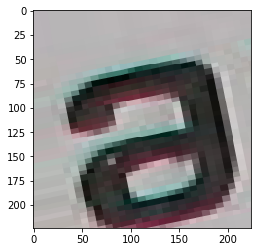

Predict 5 with probability 0.55
Predict 6 with probability 0.02 (true label)


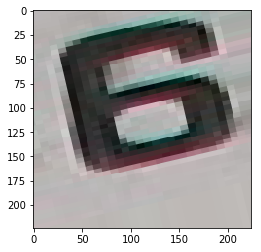

Predict 5 with probability 0.84
Predict 7 with probability 0.09 (true label)


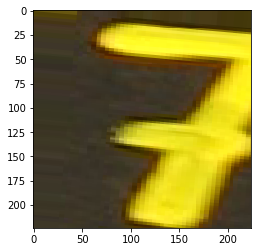

Predict 5 with probability 0.6
Predict 7 with probability 0.14 (true label)


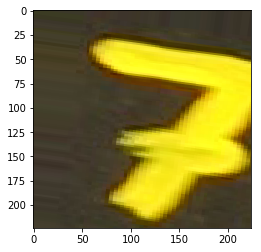

Predict 3 with probability 0.43
Predict 7 with probability 0.13 (true label)


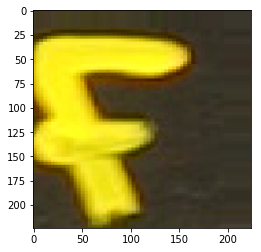

Predict 5 with probability 0.38
Predict 7 with probability 0.3 (true label)


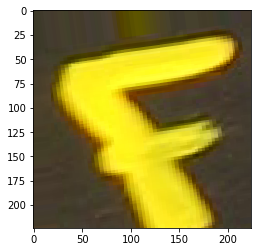

Predict 5 with probability 0.58
Predict 7 with probability 0.17 (true label)


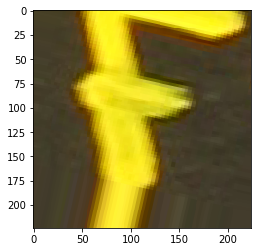

Predict 5 with probability 0.73
Predict 7 with probability 0.21 (true label)


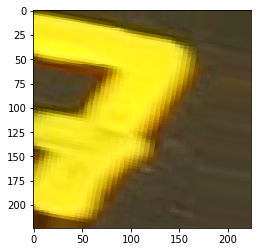

Predict 5 with probability 0.79
Predict 7 with probability 0.08 (true label)


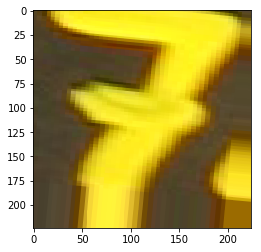

Predict 5 with probability 0.83
Predict 7 with probability 0.04 (true label)


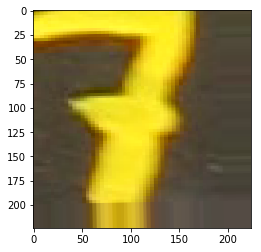

Predict 5 with probability 0.42
Predict 7 with probability 0.4 (true label)


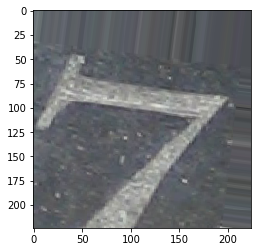

Predict 1 with probability 0.99
Predict 7 with probability 0.01 (true label)


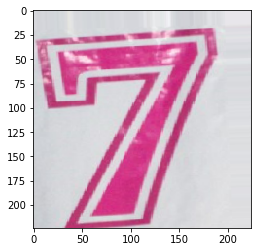

Predict 1 with probability 1.0
Predict 7 with probability 0.0 (true label)


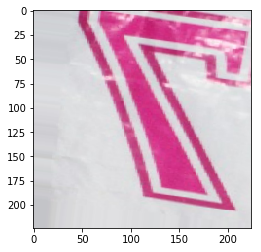

Predict 3 with probability 0.28
Predict 7 with probability 0.03 (true label)


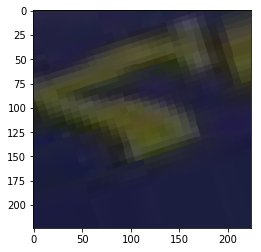

Predict 5 with probability 0.44
Predict 7 with probability 0.34 (true label)


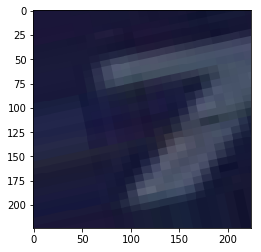

Predict 5 with probability 0.68
Predict 7 with probability 0.31 (true label)


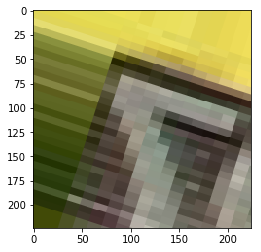

Predict 5 with probability 0.72
Predict 7 with probability 0.1 (true label)


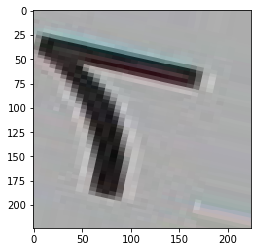

Predict 2 with probability 0.5
Predict 8 with probability 0.09 (true label)


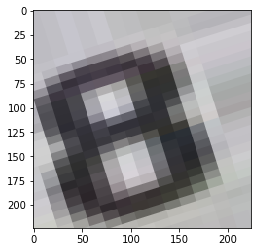

Predict 5 with probability 0.37
Predict 8 with probability 0.12 (true label)


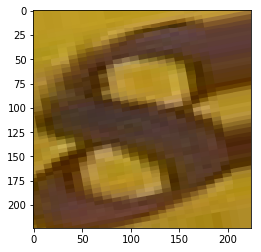

Predict 6 with probability 0.26
Predict 8 with probability 0.15 (true label)


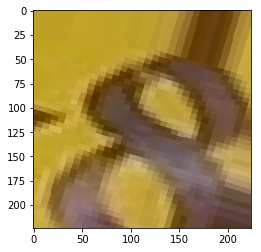

Predict 3 with probability 0.29
Predict 8 with probability 0.07 (true label)


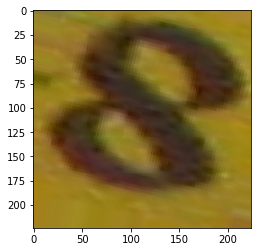

Predict 3 with probability 0.62
Predict 8 with probability 0.19 (true label)


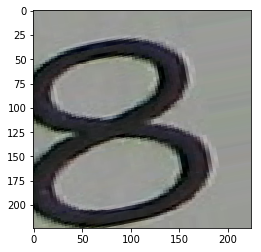

Predict 5 with probability 0.43
Predict 9 with probability 0.03 (true label)


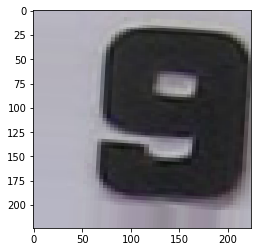

Predict 8 with probability 0.35
Predict 9 with probability 0.16 (true label)


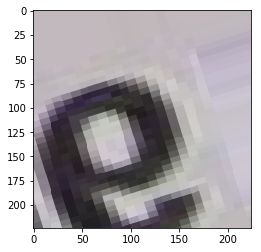

Predict 3 with probability 0.3
Predict 9 with probability 0.14 (true label)


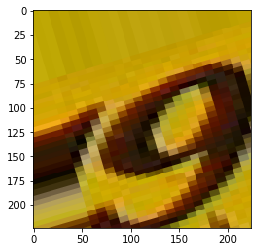

Predict 4 with probability 0.46
Predict 9 with probability 0.06 (true label)


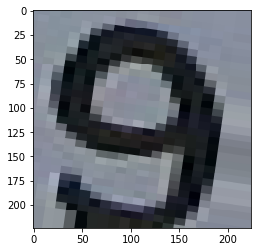

Predict 2 with probability 0.38
Predict 9 with probability 0.16 (true label)


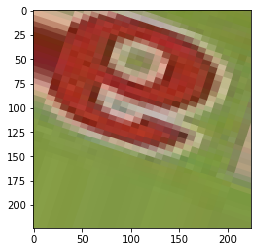

Predict 2 with probability 0.44
Predict 9 with probability 0.22 (true label)


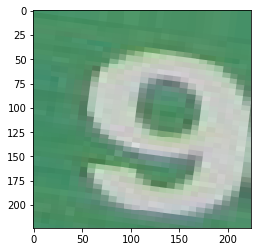

In [36]:
import pdb

error_index = np.where(error == 1)[0]
for i in range(len(error_index)):
    pred_label = np.argmax(prediction_prob[error_index[i], :])
    pred_prob = np.max(prediction_prob[error_index[i], :])
    label = np.argmax(test_label[error_index[i], :])
    prob = prediction_prob[error_index[i], label]
    print('Predict', class_label[pred_label], 'with probability', np.around(pred_prob, 2))
    print('Predict', class_label[label], 'with probability', np.around(prob, 2), '(true label)')
    plt.imshow(test_image[error_index[i]])
    plt.show()

## Bonus step - Build the model

We show here an alternative model built from scratch. This could be used instead of Steps 3 and 4. However, it provides bad accuracy if not trained with a large dataset.

In [ ]:
model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape = (width, height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), input_shape = (width, height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), input_shape = (width, height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(nb_classes, activation = 'softmax'))